# Netflix Movie Recommendation System

<h2>1 Understanding the Data </h2>

<p> Get the data from : https://www.kaggle.com/netflix-inc/netflix-prize-data/data </p>
<p> Data files : 
<ul> 
<li> combined_data_1.txt </li>
<li> combined_data_2.txt </li>
<li> combined_data_3.txt </li>
<li> combined_data_4.txt </li>
<li> movie_titles.csv </li>
</ul>
<pre>  
The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

CustomerID,Rating,Date

MovieIDs range from 1 to 17770 sequentially.
CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
Ratings are on a five star (integral) scale from 1 to 5.
Dates have the format YYYY-MM-DD.
</pre>

<h3> Example Data point </h3>

<pre>
1:
1488844,3,2005-09-06
822109,5,2005-05-13
885013,4,2005-10-19
30878,4,2005-12-26
823519,3,2004-05-03
893988,3,2005-11-17
124105,4,2004-08-05
1248029,3,2004-04-22
1842128,4,2004-05-09
2238063,3,2005-05-11
1503895,4,2005-05-19
2207774,5,2005-06-06
2590061,3,2004-08-12
2442,3,2004-04-14
543865,4,2004-05-28
1209119,4,2004-03-23
804919,4,2004-06-10
1086807,3,2004-12-28
1711859,4,2005-05-08
372233,5,2005-11-23
1080361,3,2005-03-28
1245640,3,2005-12-19
558634,4,2004-12-14
2165002,4,2004-04-06
1181550,3,2004-02-01
1227322,4,2004-02-06
427928,4,2004-02-26
814701,5,2005-09-29
808731,4,2005-10-31
662870,5,2005-08-24
337541,5,2005-03-23
786312,3,2004-11-16
1133214,4,2004-03-07
1537427,4,2004-03-29
1209954,5,2005-05-09
2381599,3,2005-09-12
525356,2,2004-07-11
1910569,4,2004-04-12
2263586,4,2004-08-20
2421815,2,2004-02-26
1009622,1,2005-01-19
1481961,2,2005-05-24
401047,4,2005-06-03
2179073,3,2004-08-29
1434636,3,2004-05-01
93986,5,2005-10-06
1308744,5,2005-10-29
2647871,4,2005-12-30
1905581,5,2005-08-16
2508819,3,2004-05-18
1578279,1,2005-05-19
1159695,4,2005-02-15
2588432,3,2005-03-31
2423091,3,2005-09-12
470232,4,2004-04-08
2148699,2,2004-06-05
1342007,3,2004-07-16
466135,4,2004-07-13
2472440,3,2005-08-13
1283744,3,2004-04-17
1927580,4,2004-11-08
716874,5,2005-05-06
4326,4,2005-10-29
</pre>

<h2> 2 Type of Machine Learning Problem </h3>

<pre>
For a given movie and user we need to predict the rating would be given by him/her to the movie. 
The given problem is a Recommendation problem 
It can also seen as a Regression problem 
</pre>

<h3> 2.1 Performance metric </h3>

<ul>
<li> Mean Absolute Percentage Error: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error </li>
<li> Root Mean Square Error: https://en.wikipedia.org/wiki/Root-mean-square_deviation </li>
</ul>


In [2]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Preprocessing</h2> 

<h3> Converting / Merging whole data to required format: u_i, m_j, r_ij</h3>

In [12]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']
    for file in files:
        
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:04:43.436826


In [13]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [16]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [15]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<h3> Checking for NaN values </h3>

In [0]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


<h3> Removing Duplicates </h3>

In [0]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


 <h3> Basic Statistics (#Ratings, #Users, and #Movies)</h3>

In [0]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


<h2>3.2 Spliting data into Train and Test(80:20) </h2>

In [0]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

<h3> Basic Statistics in Train data (#Ratings, #Users, and #Movies)</h3>

In [0]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


<h3> Basic Statistics in Test data (#Ratings, #Users, and #Movies)</h3>

In [0]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


 <h2> 3.3 Exploratory Data Analysis on Train data </h2>

In [0]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<h3> Distribution of ratings </h3>

<IPython.core.display.Javascript object>


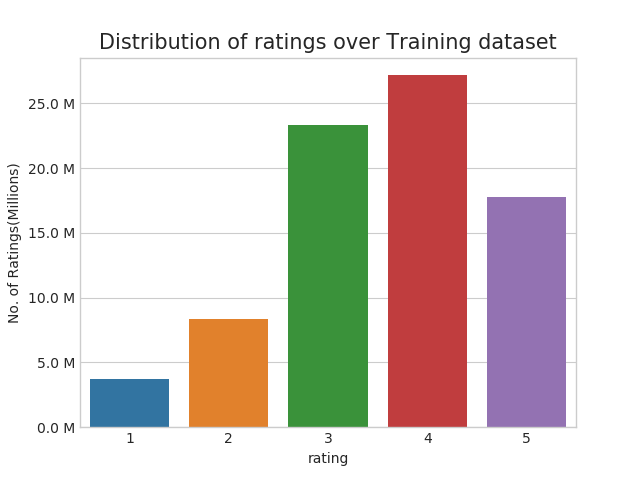

In [0]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

<p style="font-size:13px"> <b>Add new column (week day) to the data set  for analysis.</b></p>

In [0]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

train_df['day_of_week'] = train_df.date.dt.weekday_name

train_df.tail()

,movie,user,rating,date,day_of_week
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


<h3> Number of Ratings per a month </h3>

<IPython.core.display.Javascript object>


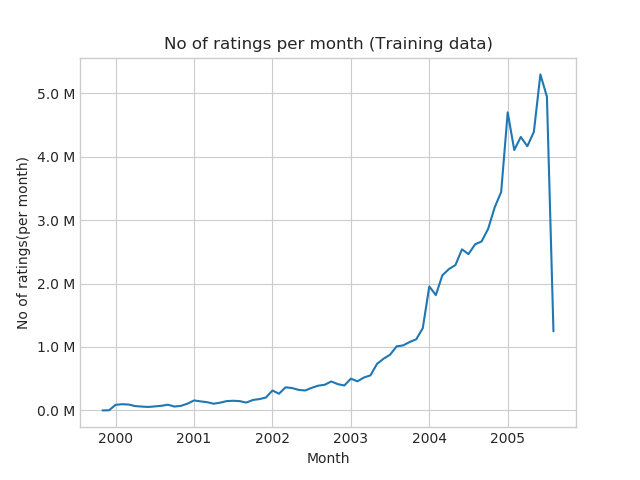

In [0]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<h3> Number of ratings on each day of the week</h3>

<IPython.core.display.Javascript object>


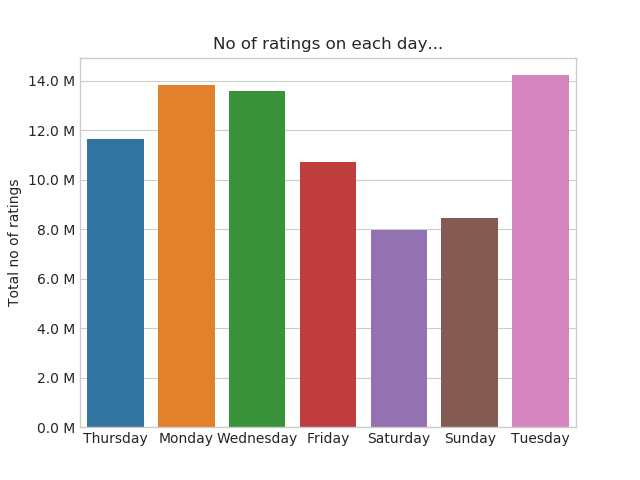

In [0]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<IPython.core.display.Javascript object>


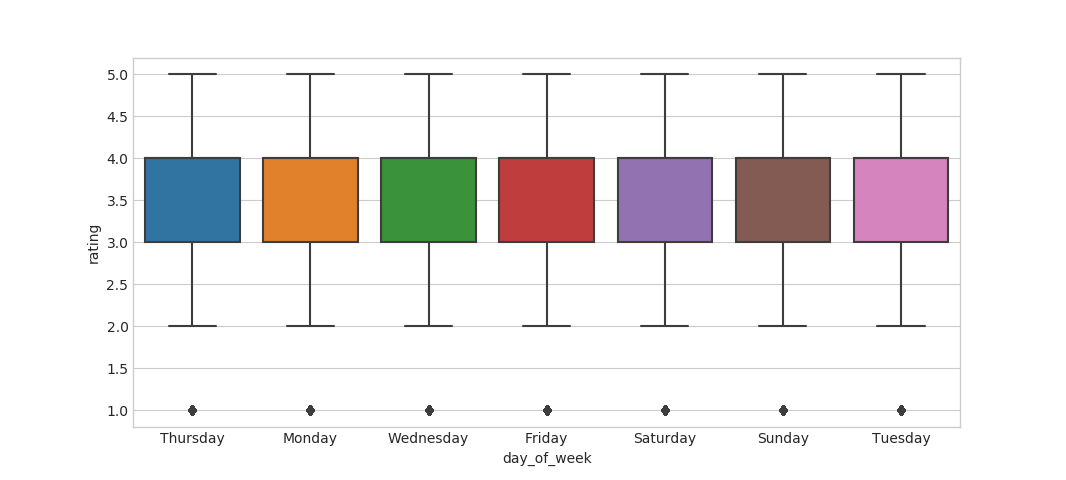

0:01:10.003761


In [0]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

#### Day of the week is not a useful feature

<h3>  Creating sparse matrix from data frame </h3>

<h4> Creating sparse matrix from train data frame </h4>

In [28]:
if os.path.isfile('train_sparse_matrix.npz'):
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
else: 

    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),) 
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
   


<h4> Creating sparse matrix from test data frame </h4>

In [29]:

if os.path.isfile('test_sparse_matrix.npz'):

    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    
else: 
   

    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    

<h3> Cold Start problem </h3>

<h4>  Cold Start problem with Users</h4>

In [0]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


##### We have to handle __new users__ ( ___75148___ ) who didn't appear in train data.

<h4> Cold Start problem with Movies</h4>

In [0]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


##### We  have to handle __346 movies__ (small comparatively) in test data

<h2> 4 Approach 1:Computing Similarity matrices to recommend movies</h2>

<h3> 4.1 Computing User-User Similarity matrix </h3>

#### Since we are having close to 405 K  users in the train matrix it is nearly impossible to to compute a the similarity matrix in a single box whose size would be of 405k*405k

<h3>4.2 Computing Movie-Movie Similarity matrix </h3>

In [25]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("File present")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

Saving it to disk 
Done..
0:10:02.736054


In [0]:
m_m_sim_sparse.shape

(17771, 17771)

- Even though we have similarity measure of each movie, with all other movies, We generally don't care much about least similar movies.


- Most of the times, only top_xxx similar items matters. It may be 10 or 100.


- We take only those top similar movie ratings and store them  in a saperate dictionary.

In [0]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [0]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

0:00:33.411700


array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
         778, 15331,  1416, 12979, 17139, 17710,  5452,  2534,   164,
       15188,  8323,  2450, 16331,  9566, 15301, 13213, 14308, 15984,
       10597,  6426,  5500,  7068,  7328,  5720,  9802,   376, 13013,
        8003, 10199,  3338, 15390,  9688, 16455, 11730,  4513,   598,
       12762,  2187,   509,  5865,  9166, 17115, 16334,  1942,  7282,
       17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947, 11981,
        4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,  5107,
        7859,  5969,  1510,  2429,   847,  7845,  6410, 13931,  9840,
        3706])

<p style='font-size:15px'><b>Similar Movies for 'Vampire Journals'</b></p>

In [0]:
mv_id = 67

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similarto this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Vampire Journals

It has 270 Ratings from users.

We have 17284 movies which are similarto this  and we will get only top most..


In [0]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity (ie.,1)
                                               # and return its indices(movie_ids)

__Top 10 similar movies__

In [0]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
13962,2001.0,Dracula: The Dark Prince
12053,1993.0,Dracula Rising
16279,2002.0,Vampires: Los Muertos
4667,1996.0,Vampirella
1900,1997.0,Club Vampire
13873,2001.0,The Breed


 <h1> 5. Approach 2: Machine Learning Models using Suprise </h1>

In [0]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path):


    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))


    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)

    
    return sample_sparse_matrix

<h2> 5.1 Sampling Data </h2>

Since it is difficult to work with whole data 
1. we are sampling 10k unique users and 1k unique movies from train data
2. we are sampling 5k unique users and 500 unique movies from test data

<h3> Build sample train data from the train data</h3>

In [26]:
path = "sample/small/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,
                                             path = path)



<h3> Build sample test data from the test data</h3>

In [27]:
path = "sample/small/sample_test_sparse_matrix.npz"
if os.path.isfile(path):    
    sample_test_sparse_matrix = sparse.load_npz(path)
    
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = "sample/small/sample_test_sparse_matrix.npz")


<h3>  Transforming data for Surprise models</h3>

In [0]:
from surprise import Reader, Dataset

<h4>  Transforming train data </h4>


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [0]:

reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

trainset = train_data.build_full_trainset() 

<h4>  Transforming test data </h4>

In [0]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

<h2> 5.2 Applying Machine Learning models </h2>

#### Utility functions for Surprise modes

In [0]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)


def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100


def run_surprise(algo, trainset, testset, verbose=True): 

    start = datetime.now()
   
    train = dict()
    test = dict()
    
   
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    
    train_preds = algo.test(trainset.build_testset())    
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

<h3>  Suprise BaselineModel </h3>
http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 


In [0]:
from surprise import BaselineOnly 

In [0]:

# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
my_bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(my_bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.822391 

Evaluating the model with train data..
time taken : 0:00:01.116752
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.074418
---------------
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:02.014073


<h3> Surprise KNNBaseline predictor </h3>
http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline 

In [0]:
from surprise import KNNBaseline

 <h4>  Surprise KNNBaseline with user user similarities</h4>

In [0]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:30.173847 

Evaluating the model with train data..
time taken : 0:01:35.970614
---------------
Train Data
---------------
RMSE : 0.33642097416508826

MAPE : 9.145093375416348

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.075213
---------------
Test Data
---------------
RMSE : 1.0726493739667242

MAPE : 35.02094499698424

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:06.220108


<h4> Surprise KNNBaseline with movie movie similarities</h4>

In [0]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:01.093096 

Evaluating the model with train data..
time taken : 0:00:07.964272
---------------
Train Data
---------------
RMSE : 0.32584796251610554

MAPE : 8.447062581998374

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.075229
---------------
Test Data
---------------
RMSE : 1.072758832653683

MAPE : 35.02269653015042

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:09.133017


<h3> Matrix Factorization Techniques </h3>

<h4>  SVD Matrix Factorization User Movie intractions </h4>

http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD 

In [0]:
from surprise import SVD

In [0]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:07.297438 

Evaluating the model with train data..
time taken : 0:00:01.305539
---------------
Train Data
---------------
RMSE : 0.6574721240954099

MAPE : 19.704901088660474

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.067811
---------------
Test Data
---------------
RMSE : 1.0726046873826458

MAPE : 35.01953535988152

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:08.671347
